<a href="https://colab.research.google.com/github/Roda10/Latent_Variable_Models/blob/main/notebooks/01_SBI_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pranavm19/SBI-Tutorial/blob/main/notebooks/01_SBI_Intro.ipynb)

## Intro to Simulation Based Inference (SBI)
**Pranav Mamidanna, PhD** (p.mamidanna22@imperial.ac.uk), April 2025

In many scientific and engineering problems, we have access to powerful **simulators** that can generate data $x$ that closely resemble real-world observations $x_{\text{obs}}$. And our interest lies in the underlying parameters $\theta$ that govern our problem of interest, often providing mechanistic or causal insight. Using **Bayesian inference**, we aim to estimate the probable values of the parameters that could have generated the observations $x_{\text{obs}}$ we have acquired, i.e., $p(\theta \mid x_{\text{obs}})$.

However, if the simulator does not yield a closed-form likelihood $p(x \mid \theta)$, standard Bayesian tools (like MCMC) become challenging or impossible. This is known as the **likelihood-free** or **simulation-based** setting.

In this notebook, we explore:
1. How, even for a seemingly simple 2D “two-moons” simulator, deriving the exact likelihood is messy.  
2. **Approximate Bayesian Computation (ABC)**, an approach that sidesteps the need for a closed-form likelihood by simulating data under proposed parameters and retaining those that generate data “close enough” to our observed dataset.  

These ideas are a foundation for **Neural Simulation-Based Inference**, which trains neural networks to approximate posteriors or likelihoods when simulations are available but explicit probability formulas are not.

In [1]:
# Uncomment the line below to ensure that your colab env has corner installed
!python -m pip install corner

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual, FloatSlider, IntSlider
import corner

### **Two Moons** _in the Posterior_

Consider the following problem - we have a simulator $\mathbf{Sim} : \theta \to x$, which computes $x$ as follows:

$$a \sim Unif\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)$$

$$r \sim Normal(0.1,0.01^2)$$

$$p = (r \cos(a) + 0.5, r \sin(a))$$

$$x^\top = p + \left( \frac{-\left| \theta_1 + \theta_2 \right|}{\sqrt{2}}, \frac{-\theta_1 + \theta_2}{\sqrt{2}} \right)$$

Which in code looks like -

In [3]:
def two_moons_sbi(theta, n_samples=100, sigma=0.01):
    """Generate a two moons posterior"""
    alpha = np.random.uniform(-np.pi/2, np.pi/2, n_samples)
    r = sigma * np.random.randn(n_samples) + 1
    x_1 = r * np.cos(alpha) + 0.5 - np.abs(theta[0] + theta[1])/np.sqrt(2)
    x_2 = r * np.sin(alpha) + (- theta[0] + theta[1])/np.sqrt(2)

    x =  np.stack([x_1, x_2], axis=-1)

    return x

And generates data that looks like below. Play around with the simulator below to get a sense of how the data looks like for different values of $\theta$.

In [4]:
def plot_data(theta1=0.5, theta2=-0.5):
    theta = np.array([theta1, theta2])
    x = two_moons_sbi(theta, n_samples=200)

    plt.figure(figsize=(4, 4))
    plt.scatter(x[:, 0], x[:, 1], s=5)
    plt.xlim(-3, 3); plt.ylim(-3, 3)
    plt.grid(True)

# Create interactive sliders
theta1_slider = FloatSlider(value=0.5, min=-2.0, max=2.0, step=0.1, description='theta1')
theta2_slider = FloatSlider(value=-0.5, min=-2.0, max=2.0, step=0.1, description='theta2')

interact(plot_data, theta1=theta1_slider, theta2=theta2_slider);


interactive(children=(FloatSlider(value=0.5, description='theta1', max=2.0, min=-2.0), FloatSlider(value=-0.5,…

> **Task 1.1** Where are the two moons?  
(Hint: how does the data look like when you simulate with $\theta$ is $(\theta_1, \theta_2)$, and $(-\theta_2, -\theta_1)$ ?)

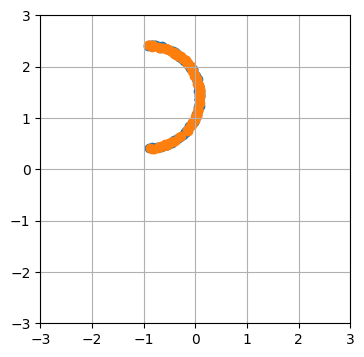

In [7]:
plt.figure(figsize=[4, 4])
# UNCOMMENT AND FILL IN THE CODE BELOW!
plt.scatter(*two_moons_sbi([0,2]).T)
plt.scatter(*two_moons_sbi([-2,0]).T)

plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.grid(True)

Play around with the simulator below to get a sense of the posterior distribution for a single observation here shown as a red star. By playing around with the theta you should (hopefully) uncover the two moons in the posterior!

In [8]:
# We'll define a global list to hold our "accepted" parameter values
accepted_params = []

def update_plots(theta1=0.0, theta2=0.0):
    """
    For the given (theta1, theta2):
    1) Generate data and plot it in the data space.
    2) Check if x_obs is within threshold distance of any point in that data.
       If yes, record (theta1, theta2) in a global list.
    3) Plot the "accepted" parameter list so far in the parameter space.
    """
    global accepted_params

    x_obs = np.array([0.0, 0.0])
    threshold = 0.2   # acceptance threshold for "close enough"
    col = 'C0' # Let's change color of samples when there is a match!

    # Generate data from user specified theta
    theta = np.array([theta1, theta2])
    x_sim = two_moons_sbi(theta, n_samples=20)

    # Check if any of the points in x_sim lie close enough to x_obs
    # We'll measure Euclidean distance from each simulated point to x_obs
    distances = np.linalg.norm(x_sim - x_obs, axis=1)
    if np.any(distances < threshold):
        accepted_params.append(theta)
        accepted_params.append(np.array([-theta2, -theta1]))
        col='C1'
    else:
        col='C0'

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Data space
    axes[0].scatter(*x_sim.T, color=col, alpha=0.6, label="Simulated data")

    # Parameter space
    axes[1].plot(theta1, theta2, 'rx', markersize=8, label=r"Current $\theta$")
    if len(accepted_params) > 0:
        axes[1].scatter(*np.array(accepted_params).T, alpha=0.3, label=r"$x_{obs} \mid \theta$")

    # Prettify
    axes[0].set_title('Data space')
    axes[0].plot(0, 0, 'r*', markersize=10, label=r"$x_{obs} = [0,0]$")
    axes[0].set_xlim(-3, 3); axes[0].set_ylim(-3, 3); axes[0].grid(True)
    axes[0].legend()
    axes[1].set_title("Parameter Space")
    axes[1].set_xlabel(r"$\theta_1$"); axes[1].set_ylabel(r"$\theta_2$")
    axes[1].set_xlim(-2.0, 2.0); axes[1].set_ylim(-2.0, 2.0)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# Create sliders for theta1 and theta2
theta1_slider = FloatSlider(value=0.5, min=-2.0, max=2.0, step=0.1, description='theta_1')
theta2_slider = FloatSlider(value=0.5, min=-2.0, max=2.0, step=0.1, description='theta_2')

interact(update_plots, theta1=theta1_slider, theta2=theta2_slider);

interactive(children=(FloatSlider(value=0.5, description='theta_1', max=2.0, min=-2.0), FloatSlider(value=0.5,…

Oh, btw, you basically did simulation based inference :)

But let's take a step back. Given we have an observation $x_{\text{obs}}$ from this data generating process, how can we infer the parameters $\theta$ that could have generated it?

**Bonus: Can we get an exact likelihood?**

Even in this simple “two-moons” simulator, the closed-form likelihood $p(x\mid\theta)$ is nontrivial to write down. Here’s the basic idea - our simulator draws:
$$
\alpha \sim \mathbf{U}\bigl(-\tfrac{\pi}{2}, \tfrac{\pi}{2}\bigr),
\quad
r \sim \mathbf{N}(0, \sigma^2),
$$
and maps $(\alpha, r)$ to a data point $x$ via:
$$
x_1 = r \cos(\alpha) + 0.25 - \dfrac{|\theta_1 + \theta_2|}{\sqrt{2}},
\quad
x_2 = r \sin(\alpha) + \dfrac{\theta_2 - \theta_1}{\sqrt{2}}.
$$

This means that we can use the **change of variables formula** to go from $(\alpha, r) \to x$. That is, we can write the density of $x$ as
$$
p(x \mid \theta) \propto ~ p(\alpha) ~ p(r) ~ \left| \dfrac{d(\alpha, r)}{d(x_1, x_2)} \right|
$$

> **Optional Task 1.2:** derive a simplified expression for the likelihood.

In larger or more realistic simulators (with more dimensions, complicated physics, etc.), deriving such an expression by hand may be **extremely** difficult or effectively impossible. **This** is why we turn to likelihood-free methods—like **Approximate Bayesian Computation** or **Neural Simulation-Based Inference**—which avoid having to evaluate $p(x\mid\theta)$ directly.


### **Approximate Bayesian Computation (ABC)**

Approximate Bayesian Computation (ABC) is a class of inference methods designed for settings where the likelihood function $p(x \mid \theta)$ is *intractable*—but we can still **simulate** from it. The basic idea is this -- simulators let us verify _whether_ a particular $\theta$ could have generated an observed $x_{obs}$! If we simulate _A LOT_ of $\theta$'s, then we can use the sampled $x$'s to _infer_ the posterior distribution!

**Ingredients list**

- A prior distribution $p(\theta)$: We can sample from this to generate candidate parameter values.
- A simulator: Given $\theta$, we simulate synthetic data $x_{\text{sim}} \sim p(x \mid \theta)$.
- A distance function $d(x_{\text{sim}}, x_{\text{obs}})$: Measures how close the simulated data is to the observed data.
- A threshold $\varepsilon$: Determines how "close" is close enough.

**The Basic ABC Algorithm**

Repeat until you have $N$ accepted samples:
1. Sample $\theta^* \sim p(\theta)$ from the prior.
2. Simulate $x_{\text{sim}} \sim p(x \mid \theta^*)$ using the simulator.
3. If $d(x_{\text{sim}}, x_{\text{obs}}) < \varepsilon$, accept $\theta^*$ as a posterior sample.

The collection of accepted $\theta$ values approximates the posterior $p(\theta \mid x_{\text{obs}})$.

> **Task 1.3** Based on the algorithm above, complete the following code to run your own ABC inference.

In [ ]:
def abc(x_obs, eps=0.1, n_samples=1000):
    """ABC algorithm for two moons model.

    Args:
        x_obs (np.ndarray): Observation from the two moons model.
        eps (float, optional): Acceptance threshold. Defaults to 0.1.
        n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.

    Returns:
        np.ndarray: Samples obtained for approximating the posterior p(theta|x_obs).
        np.ndarray: Acceptance flag for each sample.
    """
    samples = []
    accept_flag = []
    n_accepted = sum(accept_flag)
    n_sim = 100 # samples to simulate each time

    # Make a progress bar to see how quickly we accept
    pbar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    while sum(accept_flag) < n_samples:
        ## TO-DO: Write the code to sample a parameter from the prior,
        # simulate data, and compute the distance to the observed data

        # Bookkeeping
        samples.append(theta_candidate)

        if np.any(dist < eps):
            accept_flag.append(1) # bookkeeping accepted thetas
            n_accepted += np.sum(dist < eps)
            acceptance_ratio = n_accepted / (len(samples) * n_sim)
            pbar.update(1)
            pbar.set_postfix_str(f"acceptance_ratio={acceptance_ratio:.3f}")
        else:
            accept_flag.append(0)

    pbar.close()
    return np.array(samples), np.array(accept_flag)

In [ ]:
# Verify this runs without any errors!
candidates, flags = abc([0, 0])

Let's see ABC in action! Can it compete with how you explored the parameter space previously?

In [ ]:
from IPython.display import clear_output
global_accepted_samples = []

def run_abc(n_samples=100, eps=0.1):
    """
    Each time run_interact is pressed:
    1. Run ABC to get n_samples new samples.
    2. Display them one by one on the plot, maintaining history of all previous runs.
    """
    global global_accepted_samples

    # Run ABC with a single observed point [0,0]
    samples, accept_flag = abc(np.array([0.0, 0.0]), eps, n_samples)

    # Show new samples one-by-one
    for i, sample in enumerate(samples):
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

        # First plot all previously accepted samples
        if global_accepted_samples:
            ax.scatter(*np.array(global_accepted_samples).T, alpha=0.6, label='Previous samples')

        # Plot current sample
        ax.plot(sample[0], sample[1], 'rx', markersize=10, label='Current sample')

        # If accepted, add to plot and global list
        if accept_flag[i] == 1:
            global_accepted_samples.append(sample)
            ax.scatter(sample[0], sample[1], alpha=0.6)

        # Prettify
        ax.set_xlim(-2, 2); ax.set_ylim(-2, 2)
        ax.set_xlabel(r'$\theta_1$'); ax.set_ylabel(r'$\theta_2$')
        ax.set_title(f"ABC Posterior Samples")

        clear_output(wait=True)
        plt.show()
        # plt.pause(0.005)  # Small pause for visualization

samples_slider = IntSlider(value=50, min=10, max=200, step=10, description='Number of samples to acquire')
eps_slider = FloatSlider(value=0.2, min=0.1, max=1, step=0.1, description='Acceptance threshold')

interact_manual(run_abc, n_samples=samples_slider, eps=eps_slider);

In [ ]:
# Plot the posterior distribution using corner
samples, accept_flag = abc([0, 0])
figure = corner.corner(samples[accept_flag==1], labels=['theta1', 'theta2'])

> **Task 1.4 Discuss with your neighbour**
1. How does the inference (the approximate posterior distribution) depend on the number of samples in ABC?
2. How does changing epsilon threshold affect the posterior?
3. Here, we have performed inference for a single observation. What happens when we have multiple $x_{obs}$? Do you think ABC scales well?

In [ ]:
from google.colab import runtime
runtime.unassign()

### Outro

While ABC is very simple and elegant, it can be quite inefficient in high dimensions, or when choosing the right distance metric or threshold is hard. These limitations motivate more scalable approaches like **Neural Simulation-Based Inference (Neural SBI)**, which we will cover next.

Click below to open the notebook in a new window.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pranavm19/SBI-Tutorial/blob/main/notebooks/02_NFlows.ipynb)